## Importing Dependencies

In [2]:
import sqlite3
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report 
from sklearn.model_selection import GridSearchCV
from scipy import stats


import tensorflow as tf


## Getting data from database

In [3]:
# Getting url for database
weather_url = "https://techassessment.blob.core.windows.net/aiap18-assessment-data/weather.db"
air_quality_url = " https://techassessment.blob.core.windows.net/aiap18-assessment-data/air_quality.db"

# Request
weather_response = requests.get(weather_url)
air_quality_response = requests.get(air_quality_url)

# Save db
with open('data/weather.db', 'wb') as f:
    f.write(weather_response.content)

with open('data/air_quality.db', 'wb') as f:
    f.write(air_quality_response.content)

# Define the database file path
weather_db_path = 'data/weather.db'
air_quality_db_path = 'data/air_quality.db'

# Connect to the weather database
weather_conn = sqlite3.connect(weather_db_path)
air_quality_conn = sqlite3.connect(air_quality_db_path)

# Define a query
weather_query = "SELECT * FROM weather" 
air_quality_query = "SELECT * FROM air_quality" 

# Execute the query and load the results into a Pandas DataFrame
weather_df = pd.read_sql_query(weather_query, weather_conn)
air_df = pd.read_sql_query(air_quality_query, air_quality_conn)


# Close the connection
weather_conn.close()
air_quality_conn.close()

## Transforming data

#### Duplicate data

In [4]:
# Drop duplicate data
weather_df = weather_df.drop_duplicates()
air_df = air_df.drop_duplicates()

# Getting dataframe for duplicated row for air_quality data
duplicates = air_df[air_df.duplicated('data_ref',keep=False)]

# Function to merge row
def merge_rows(group):
    merged = group.iloc[0].copy()
    for i in range(1, len(group)):
        for col in group.columns:
            if pd.isna(merged[col]) or merged[col] in [None, '-', '--']:
                merged[col] = group.iloc[i][col] if not pd.isna(group.iloc[i][col]) and group.iloc[i][col] not in [None, '-', '--'] else merged[col]
    return merged

# Merging row
merged_rows = duplicates.groupby('data_ref').apply(merge_rows).reset_index(drop=True)

# Merging psi and pm25 into same data frame
non_duplicates = air_df[~air_df['data_ref'].isin(duplicates['data_ref'])]
final_air_df = pd.concat([non_duplicates, merged_rows], ignore_index=True)

# Merge both weather and air quality data together
df = pd.merge(weather_df, final_air_df, on='date', how='inner')

C:\Users\Hyeen\AppData\Local\Temp\ipykernel_57488\412932008.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_rows = duplicates.groupby('data_ref').apply(merge_rows).reset_index(drop=True)


In [5]:
df.head()

,data_ref_x,date,Daily Rainfall Total (mm),Highest 30 Min Rainfall (mm),Highest 60 Min Rainfall (mm),Highest 120 Min Rainfall (mm),Min Temperature (deg C),Maximum Temperature (deg C),Min Wind Speed (km/h),Max Wind Speed (km/h),...,pm25_north,pm25_south,pm25_east,pm25_west,pm25_central,psi_north,psi_south,psi_east,psi_west,psi_central
0,4d4d20c2-0167-4bc2-a62c-4df6e11fb2ea,01/04/2014,-,2,2,2,28.4,32.4,7.5,25.9,...,20,16,18,23,19,58,56,57,66,59
1,c9d3c825-fd94-4e61-a4bc-2cf0f2208de0,02/04/2014,0,0,0,--,28.8,32.6,--,33.1,...,18,14,-,22,16,57,53,54,61,56
2,6d445ffb-d4c2-4f94-a27e-224fabe46d10,03/04/2014,0,0,0,0,29.3,--,--,43.2,...,12,12,10,14,10,55,53,52,59,54
3,7a404c50-710f-451a-9a42-a66bb783a3d0,04/04/2014,0,0,0,0,28.6,32.4,7.4,33.1,...,--,-,24,19,25,58,57,55,-,56
4,0d3194a7-ad1a-456e-9bf8-b1bae730977b,05/04/2014,23.4,15.2,17.2,17.4,26.4,28,5.4,28.1,...,18,19,21,13,17,64,64,66,-,66


#### Data dtypes

In [6]:
# Convert date to datetime format
df['date'] = pd.to_datetime(df['date'], format='%d/%m/%Y')

# Function to convert object to numerical
def convert_object_numerical(df,columns):
    for column in columns:
        df[column] = df[column].apply(pd.to_numeric, errors='coerce')
    
    return df

# Specify the columns to conver to numeric
columns = ['Daily Rainfall Total (mm)','Highest 30 Min Rainfall (mm)','Highest 60 Min Rainfall (mm)','Highest 120 Min Rainfall (mm)','Min Temperature (deg C)','Maximum Temperature (deg C)','Min Wind Speed (km/h)',
           'Max Wind Speed (km/h)','pm25_north','pm25_south','pm25_east','pm25_west','pm25_central','psi_north','psi_south','psi_east','psi_west','psi_central']

# Transforming dtaframe
df = convert_object_numerical(df,columns)



#### Missing values

In [7]:
# Assigning feature with na value 
missing_value_features = [feature for feature in df if df[feature].isna().sum() > 0]

# Replace missing values with median value
for feature in missing_value_features:
    df[feature].fillna(df[feature].median(),inplace=True)

C:\Users\Hyeen\AppData\Local\Temp\ipykernel_57488\1883912240.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(df[feature].median(),inplace=True)
C:\Users\Hyeen\AppData\Local\Temp\ipykernel_57488\1883912240.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

#### Consistency in Data

In [8]:
# Mapping dictionary
dew_mapping = {
    'High': 'High',
    'Very High': 'Very High',
    'Very Low': 'Very Low',
    'Moderate': 'Moderate',
    'Low': 'Low',
    'High Level': 'High',
    'H': 'High',
    'HIGH': 'High',
    'high': 'High',
    'very high': 'Very High',
    'Extreme': 'Extreme',
    'VERY HIGH': 'Very High',
    'VH': 'Very High',
    'M': 'Moderate',
    'MODERATE': 'Moderate',
    'LOW': 'Low',
    'Normal': 'Moderate',  # Assuming 'Normal' is akin to 'Moderate'
    'Minimal': 'Very Low',  # Assuming 'Minimal' is akin to 'Very Low'
    'VL': 'Very Low',
    'very low': 'Very Low',
    'low': 'Low',
    'moderate': 'Moderate',
    'Below Average': 'Low',  # Assuming 'Below Average' is akin to 'Low'
    'L': 'Low',
    'VERY LOW': 'Very Low'
}

# Mapping dew point data
df['Dew Point Category'] = df['Dew Point Category'].replace(dew_mapping)

# Mapping dictionary for wind direction
wind_direction_mapping = {
    'SW': 'Southwest',
    'SW.': 'Southwest',
    'southwest': 'Southwest',
    'SOUTHEAST': 'Southeast',
    'southeast': 'Southeast',
    'SE': 'Southeast',
    'SE.': 'Southeast',
    'NORTHEAST': 'Northeast',
    'northeast': 'Northeast',
    'NE': 'Northeast',
    'NE.': 'Northeast',
    'NORTHWEST': 'Northwest',
    'northwest': 'Northwest',
    'NW': 'Northwest',
    'NW.': 'Northwest',
    'Northward': 'North',
    'NORTH': 'North',
    'north': 'North',
    'N': 'North',
    'N.': 'North',
    'Southward': 'South',
    'SOUTH': 'South',
    'south': 'South',
    'S': 'South',
    'S.': 'South',
    'WEST': 'West',
    'west': 'West',
    'W': 'West',
    'W.': 'West',
    'EAST': 'East',
    'east': 'East',
    'E': 'East',
    'E.': 'East'
}

# Mapping wind directioin
df['Wind Direction'] = df['Wind Direction'].replace(wind_direction_mapping)


## Feature engineering

#### Custom Feature

In [9]:
# Average wind speed 
df['average_wind_speed'] = (df['Min Wind Speed (km/h)'] + df['Max Wind Speed (km/h)']) /2

# Average temperature
df['average_temperature'] = (df['Min Temperature (deg C)']+ df['Maximum Temperature (deg C)']) /2

# Average psi
df['psi_average'] = (df['psi_north'] + df['psi_central'] + df['psi_east'] + df['psi_south'] + df['psi_west']) /5

# Average pm25
df['pm25_average'] = (df['pm25_central'] + df['pm25_north'] + df['pm25_south'] + df['pm25_east'] + df['pm25_west']) / 5

#### Dropping feature

In [10]:
# Assign columns to drop
columns_to_drop = ['pm25_north','pm25_south','pm25_east','pm25_west','pm25_central','psi_central',
                   'psi_north','psi_south','psi_east','psi_west',
                   'data_ref_y','data_ref_x', 
                   'Highest 30 Min Rainfall (mm)', 'Highest 60 Min Rainfall (mm)','Highest 120 Min Rainfall (mm)',
                   'Min Wind Speed (km/h)', 'Max Wind Speed (km/h)',
                   'Min Temperature (deg C)', 'Maximum Temperature (deg C)']

df = df.drop(columns=columns_to_drop)

Seperating Feature

In [11]:
# Log data 
def normalizing(df,features):
    for feature in features:
        if 0 in df[feature]:
            pass
        else:
            df[feature] = np.log(df[feature])
    return df

In [12]:
# Label class
classifier = 'Daily Solar Panel Efficiency'

# Categorical feature
ohe_feature = ['Wind Direction']
ode_feature = ['Dew Point Category']

# Numerical feature
num_feature = [ feature for feature in df if feature not in ohe_feature+ode_feature and feature not in ['date',classifier]]

df = normalizing(df,num_feature)
    
std_feature = ['Air Pressure (hPa)','Wet Bulb Temperature (deg F)','average_wind_speed']
minmax_feature = ['Daily Rainfall Total (mm)','Sunshine Duration (hrs)','Cloud Cover (%)','Relative Humidity (%)','average_temperature','psi_average','pm25_average']



In [ ]:
num_feature

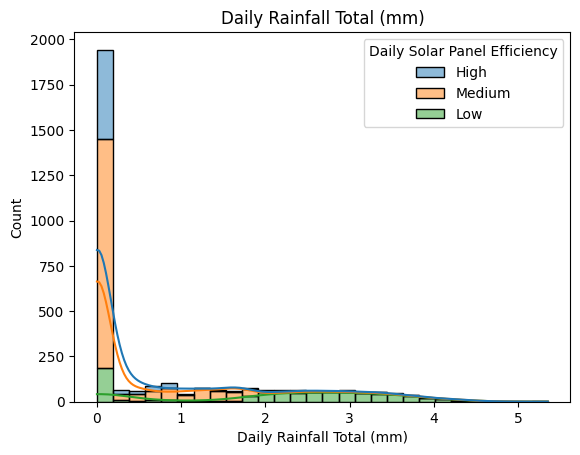

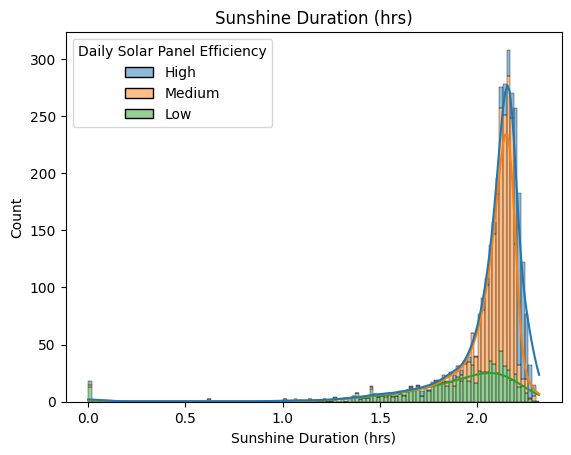

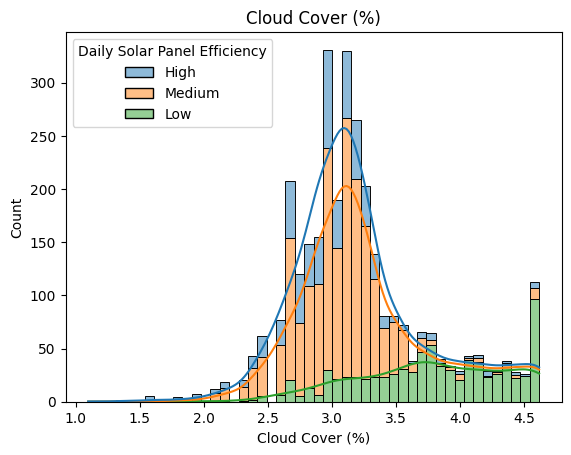

C:\Users\Hyeen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


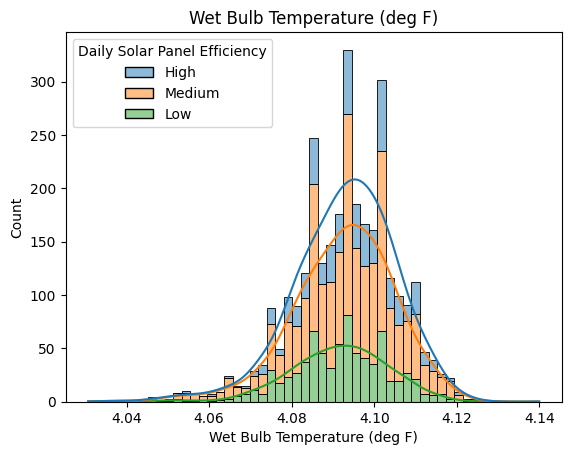

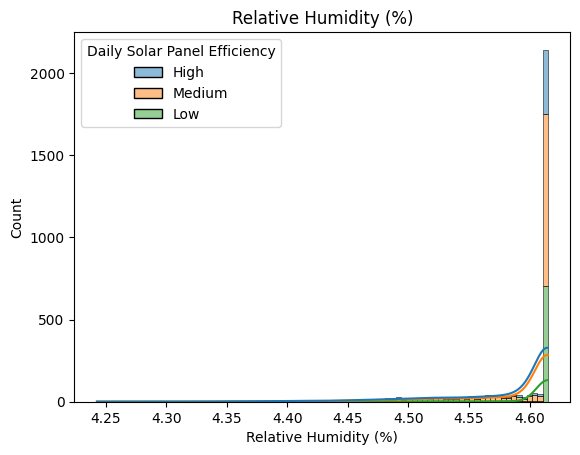

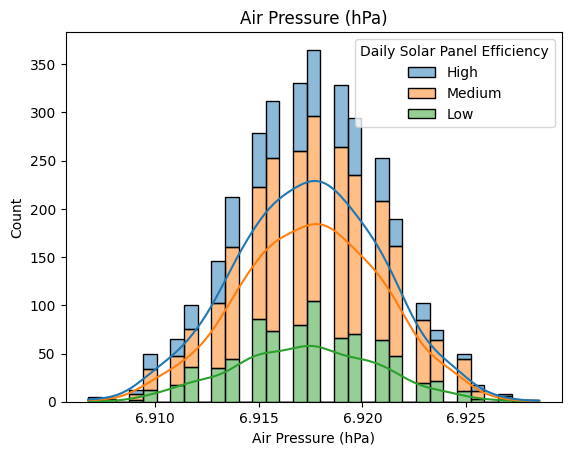

C:\Users\Hyeen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


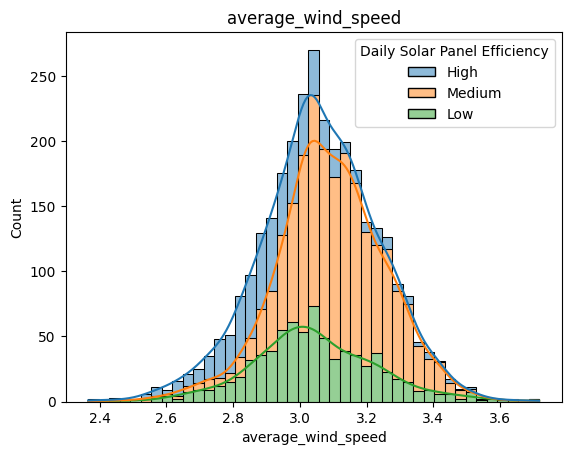

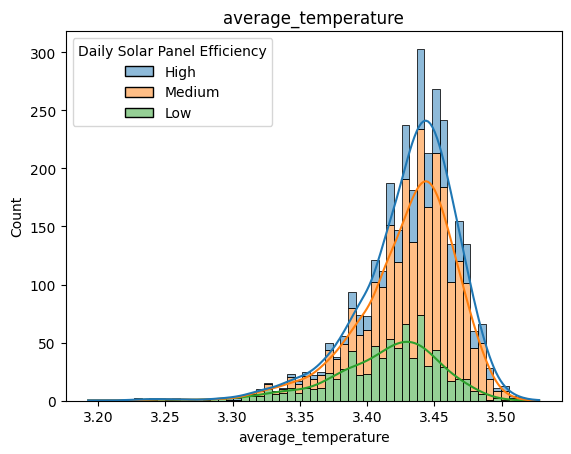

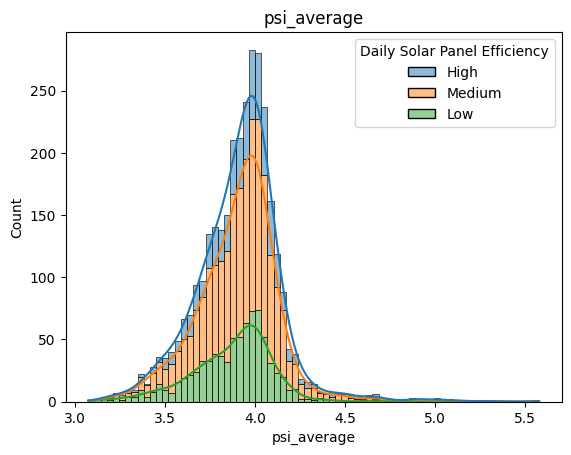

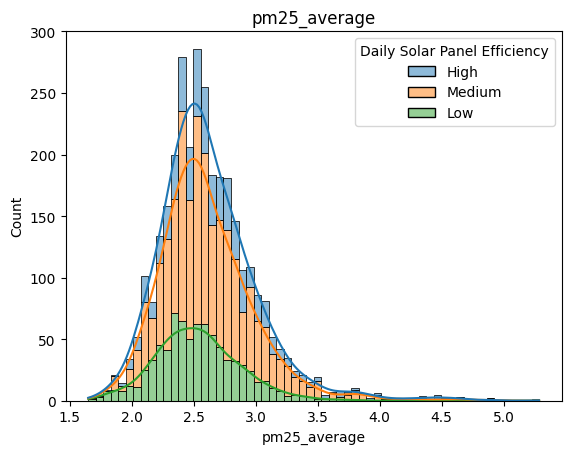

In [191]:
for feature in num_feature:
    data = df.copy()
    data[feature] = np.log1p(data[feature])
    sns.histplot(data=data, x=feature, hue=classifier,kde=True, multiple='stack' )
    plt.title(feature)
    plt.show()

## Outliers

In [13]:
mask = np.ones(len(df), dtype=bool)

for feature in num_feature:
   z_scores = np.abs(stats.zscore(df[feature]))
   feature_mask = z_scores < 3
   mask &= feature_mask

   df_filtered = df[mask]

In [14]:
df_filtered.head()

,date,Daily Rainfall Total (mm),Sunshine Duration (hrs),Cloud Cover (%),Wet Bulb Temperature (deg F),Relative Humidity (%),Air Pressure (hPa),Dew Point Category,Wind Direction,Daily Solar Panel Efficiency,average_wind_speed,average_temperature,psi_average,pm25_average
1,2014-04-02,0.0,7.57,23.0,59.2,100.0,1005,Very High,South,Medium,20.55,30.70,56.2,16.4
2,2014-04-03,0.0,6.72,16.0,59.7,98.5,1005,Low,East,Medium,25.60,30.65,54.6,11.6
3,2014-04-04,0.0,7.55,20.0,59.1,100.0,1011,Very High,West,Medium,20.25,30.50,55.0,18.6
4,2014-04-05,23.4,5.27,74.0,58.9,100.0,1012,Very High,East,Low,16.75,27.20,61.8,17.6
6,2014-04-07,10.0,5.75,40.0,58.6,100.0,1008,High,East,Low,25.40,31.55,46.6,12.6


#### Pipeline

In [192]:
# Norminal Encoder
ohe_pipeline = Pipeline(steps=[
    ('OneHotEncoder',OneHotEncoder())
])

# Ordinal Encoder
ode_pipeline = Pipeline(steps=[
    ('OrdinalEncoder',OrdinalEncoder())
])

# Standard Scaler
num_standard = Pipeline(steps=[
    ('StandardScaler',StandardScaler())
])

# Min Max Scaler
num_minmax = Pipeline(steps=[
    ('MinMaxScaler',MinMaxScaler())
])

# Column Transformer Pipe
column_transformer = ColumnTransformer([
    ('nominal transformer', ohe_pipeline, ohe_feature),
    ('rank transformer', ode_pipeline, ode_feature),
    ('numerical standard', num_standard,std_feature),
    ('numerical minmax', num_minmax,minmax_feature)

])

# Pipeline for preprocessing
pipeline = Pipeline(steps=[
    ('preprocessing', column_transformer)
])

In [ ]:
pipeline

## Scaling dataset

Since it is a unbalanced data i will be scaling the data

In [194]:
# Function to fit and scale data
def scale_data(df):
    X = df.drop(columns=classifier)
    y = df[classifier]

    # Data preprocessing
    X = pipeline.fit_transform(X)

    # Spliting dataframe with train test split
    X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=25)

    
    # Oversample in training data
    ros = RandomOverSampler()
    X_train, y_train = ros.fit_resample(X_train,y_train)


    return X_train, X_test, y_train, y_test

In [221]:
X_train, X_test, y_train, y_test = scale_data(df)

In [224]:
X_train, X_test, y_train, y_test = scale_data(df_filtered)

## Train model

In [222]:
models = {
    "KNeighbors Classifer" : KNeighborsClassifier(),
    "GaussianNB" : GaussianNB(),
    "SVM" : SVC(),
    "Random Forest" : RandomForestClassifier(),
    "Decision Tree" : DecisionTreeClassifier() 
}

In [225]:
model_list = []
report = []

for i in range(len(models)):
    # Getting model
    model = list(models.values())[i]


    # Train model
    model.fit(X_train, y_train) 

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Evaluate Train and Test dataset
    report.append(classification_report(y_test,y_test_pred))
    

    model_list.append(list(models.keys())[i])
    print("-------------------------------")
    print(list(models.keys())[i])
    print(report[i])


-------------------------------
KNeighbors Classifer
              precision    recall  f1-score   support

        High       0.39      0.53      0.45       115
         Low       0.32      0.42      0.36       114
      Medium       0.77      0.57      0.65       303

    accuracy                           0.53       532
   macro avg       0.49      0.51      0.49       532
weighted avg       0.59      0.53      0.55       532

-------------------------------
GaussianNB
              precision    recall  f1-score   support

        High       0.61      0.70      0.65       115
         Low       0.76      0.70      0.73       114
      Medium       0.83      0.81      0.82       303

    accuracy                           0.76       532
   macro avg       0.73      0.74      0.73       532
weighted avg       0.77      0.76      0.77       532

-------------------------------
SVM
              precision    recall  f1-score   support

        High       0.62      0.73      0.67       1

We can see that random forest give a better result without any parameters and removing outliers improve the result

Hyperparameter Tunining

In [ ]:
RandomForestClassifier()

In [238]:
param = {
'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
'max_features': ['auto', 'sqrt',None],
'min_samples_leaf': [1, 2, 4],
'min_samples_split': [2, 5, 10],
'n_estimators': [100, 200, 400, 600, 800]}



In [239]:
gs = GridSearchCV(RandomForestClassifier(), param, cv= 3, scoring='accuracy',verbose=3)

gs.fit(X_train,y_train)

Fitting 3 folds for each of 1485 candidates, totalling 4455 fits
[CV 1/3] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 2/3] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 3/3] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 1/3] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 2/3] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 3/3] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 1/3] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=nan total tim

C:\Users\Hyeen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
1485 fits failed out of a total of 4455.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1485 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Hyeen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Hyeen\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-pac

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100,
                                       None],
                         'max_features': ['auto', 'sqrt', None],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200, 400, 600, 800]},
             scoring='accuracy', verbose=3)

In [240]:
gs.best_score_

0.9592623176438205

In [241]:
gs.best_params_

{'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 600}

In [243]:
model = RandomForestClassifier()
model.set_params(**gs.best_params_)
model.fit(X_train,y_train)
y_test_pred = model.predict(X_test)

# Evaluate Train and Test dataset
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

        High       0.92      0.71      0.80       115
         Low       0.81      0.73      0.77       114
      Medium       0.85      0.96      0.90       303

    accuracy                           0.86       532
   macro avg       0.86      0.80      0.83       532
weighted avg       0.86      0.86      0.85       532

